In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sbi.utils as utils
from sbi.inference import infer

In [2]:
food_chain_length = 4
simulation_length = 200

In [3]:
H0 = torch.Tensor(
    [
        100,  # apex predator
        200,
        300,
        400   # antapex prey
    ]
)

In [4]:
def simulator(theta):
    theta = theta.view((food_chain_length, 3))

    zero = torch.zeros((1,))
    dt = 0.5
    epsilon = 5

    out = torch.zeros((food_chain_length, simulation_length))
    out[:, 0] = H0

    H = H0
    for t in range(1, simulation_length):
        big_H = torch.stack(
            [
                H,                              # self
                torch.cat([zero, H[:-1]]) * H,  # self * predator
                torch.cat([H[1:],  zero]) * H   # self * prey
            ],
            axis=1
        )

        H = H + dt * torch.sum(big_H * theta, axis=1) + epsilon * torch.randn(H.shape)
        H = torch.maximum(H, zero)
        out[:, t] = H
    
    return out[None, :, :]

In [5]:
a = 0.1
b = 5e-5
c = 0.04

theta = torch.Tensor(
    [
        # self, self*predator, self*prey
        [   -c,            -b,         b],  # apex predator
        [   -c,            -b,         b],
        [   -c,            -b,         b],
        [    a,            -b,         b],  # antapex prey
    ]
).view((food_chain_length * 3))

In [6]:
Hs = simulator(theta)

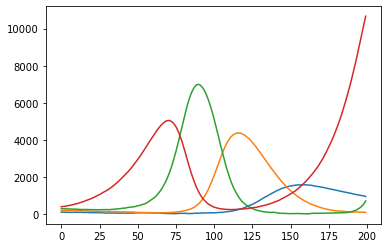

In [7]:
for h in range(food_chain_length):
    plt.plot(Hs[0, h, :])

In [8]:
num_dim = 3 * food_chain_length
prior = utils.BoxUniform(low=torch.zeros(num_dim), high= 2 * theta)

In [9]:
embedding = nn.Sequential(
    nn.Conv1d(food_chain_length, 16, kernel_size=5),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Conv1d(16, 16, kernel_size=5),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(3072, 20)
)

In [10]:
embedding(Hs)

tensor([[-0.2196,  0.2553, -0.1672, -0.3288, -0.5403, -0.2254,  0.5802, -0.2302,
          0.0610, -0.0377,  0.4710,  0.3677,  0.3991,  0.5269,  0.1189,  0.2843,
          0.0185,  0.2572,  0.0452,  0.6224]], grad_fn=<AddmmBackward>)

In [11]:
from sbi import utils
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      embedding_net=embedding)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

# run the inference procedure on one round and 10000 simulated data points
theta_samples, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=5000)

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

In [12]:
x.shape

torch.Size([5000, 4, 200])

In [13]:
embedding(x)

tensor([[-0.0068, -0.0105, -0.0030,  ..., -0.0068,  0.0050,  0.0032],
        [-0.0068, -0.0105, -0.0030,  ..., -0.0068,  0.0050,  0.0032],
        [-0.0068, -0.0105, -0.0030,  ..., -0.0068,  0.0050,  0.0032],
        ...,
        [-0.0068, -0.0105, -0.0030,  ..., -0.0068,  0.0050,  0.0032],
        [-0.0068, -0.0105, -0.0030,  ..., -0.0068,  0.0050,  0.0032],
        [-0.0068, -0.0105, -0.0030,  ..., -0.0068,  0.0050,  0.0032]],
       grad_fn=<AddmmBackward>)

In [14]:
density_estimator = inference.append_simulations(theta_samples, x).train()
posterior = inference.build_posterior(density_estimator)

Neural network successfully converged after 43 epochs.


In [15]:
theta_samples.shape

torch.Size([5000, 12])

In [16]:
observation = simulator(theta)
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = utils.pairplot(samples,
                #    limits=[[0,0.5],[0,1e-4],[0,0.5], [0, 2e-4]],
                   points=theta,
                   points_offdiag={'markersize': 6},
                   points_colors='r',
                   fig_size=(6,6))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the remaining
                        10000 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.


KeyboardInterrupt: 